<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/pyRecLab_MostPopular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://youtu.be/MEY4UK4QCP4" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: pyreclab - Most popular e Item average rating. 

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile para recomendación no personalizada: **Most Popular** e **Item Average Rating**.




## Configuración inicial 
**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    372      0 --:--:--  0:00:01 --:--:--   372
100 1546k  100 1546k    0     0   308k      0  0:00:05  0:00:05 --:--:--  461k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    507      0 --:--:-- --:--:-- --:--:--   507
100  385k  100  385k    0     0   152k      0  0:00:02  0:00:02 --:--:--  474k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    515      0 --:--:-- --:--:-- --:--:--   514
100  230k  100  230k    0     0   114k      0  0:00:02  0:00:02 --:--:--  448k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip3 install pyreclab --upgrade

Requirement already up-to-date: pyreclab in /home/bahz/anaconda3/lib/python3.8/site-packages/pyreclab-0.1.14-py3.8-linux-x86_64.egg (0.1.14)


**Paso 3:** Importamos librerías de python que vamos a utilizar

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar
**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [31]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head(100)

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561
...,...,...,...,...
95,1,116,3,878542960
96,1,117,3,874965739
97,1,118,3,875071927
98,1,120,1,875241637


In [7]:
# Ahora queremos realizar una observación rápida de los ratings 
df_train.describe()[['rating']]

,rating
count,80000.000000
mean,3.526463
std,1.124429
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Distribución de peliculas por género:

<AxesSubplot:>

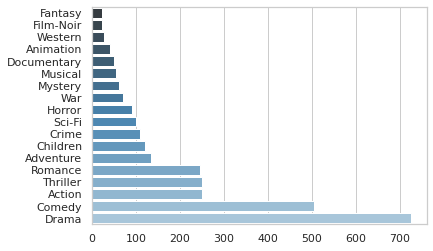

In [10]:
genre_columns = ['Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

**Pregunta:** Explique cómo funciona most popular y average rating. 
¿Qué problemas podría encontrar al utilizar cada uno de ellos?. 

**Respuesta:** Respecto a most popular y AVG Rating la recomendación se basa en los datos de ratings previos, el algoritmo _**most popular**_ es directo y simplemente recomienda lo que a gustado en mayor medida a las personas, en general (podría ser sub-dividida en grupos, basado en una encuesta inicial), esto permite así empezar en tibio y esperar a que el usuario entregue datos relevantes en cuanto al gusto posteriormente (Por eso es totalmente desvinculada al gusto, pues usa lo mas popular). una vez se obtiene un vector de relvancia so se aun retroalimentacion de gustos existen cambios.

Mientras que el recomendador de _**Calificación promedio**_ usa el promedio de calificaciones que ha obtenido de los demás usuarios, igualmente es independiente de los gustos, pero ofrece un espacio inicial de recomendación.

problemáticas que ofrecen ambos son visibles debido a que las poblaciones con las que interactúan no tienen una uniformidad en los gustos y dado el caso trae inconvenientes para personas que ya han empezado a calificar pues no responde diatónicamente a sus gustos. 

En en ambos casos se reflejada directamente la población actual, y por tanto entre mas gente califique con distintos gusto la distribución tomara un forma normal o en el peor de los casos un forma semi constante (si todos los grupos de usuarios son opuestos y sin intersección). En ambos casos un arreglo simple es la categorización para evitar que poblaciones con muchas diferencias afecten a otras poblaciones mas homogéneas

## Most popular

In [11]:
# Definicion de objeto "most popular"
most_popular = pyreclab.MostPopular(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "most_popular" solo registra los items más populares en el set de entrenamiento  
most_popular.train()

Calculamos métricas de ranking ($nDCG@10$ y $MAP$) para conocer el rendimiento de nuestro recomendador en el set de test. 

1. nDCG@10: normalized discounted cummulative gain @ 10 

$DCG = \sum{ \frac{2^{rel} -1 }{log_2(i+1)}}$

$nDCG = \frac{DCG}{IDCG}$

$IDCG: $ ideal DCG donde todos los relevantes están en las primeras posiciones. 

$nDCG@10$ es la métrica nDCG para los primeros 10 items recomendados. 

2. MAP: mean average precision 

$AveP = \frac{\sum{P(k) * rel(k)}}{total items relevantes}$

$MAP = \sum{\frac{AveP(u)}{U}}$

donde: 
$P(k):$ precision en posicion k (P@10 or "Precision at 10" corresponde al numero de items relevantes en las primeras 10 posiciones) <br>  
$rel(k): $ 0 si el item no es relevante o 1 si es relevante. <br>

**TIP:** relevante por ejemplo es si es que el usuario le dió más de 3 estrellas de rating a un item. <br>



**Ejemplo**

Sistema me recomendó estas 10 películas: 
[13,15,35, 28, 3, 1, 100, 122]

El usuario en realidad prefirió estas películas: 
[13,90,12, 2, 3, 384, 219, 12938]

Construimos lista asignando un 1 si es relevante o 0 si no: <br> 
[1, 0, 0,0,1,0,0,0]

Sobre esta lista calculamos las métricas nDCG@K y MAP (serán vistas en más detalle en clases). 











In [12]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 10

recommendList, maprec, ndcg = most_popular.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.2889129174597905
NDCG@10: 0.1598011823409535


In [32]:
# Calcular las recomendaciones para un usuario en particular (id =2)
user_id = 943

ranking = [int(r) for r in most_popular.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 943: [50, 100, 258, 181, 294, 286, 121, 300, 174, 127]


In [33]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0



**Pregunta** Cambiar el id de usuario, qué se puede observar de las recomendaciones?




**Respuesta:** Si realiza cambios respecto a las relevancias obtenidas del usuario con diferente recomendación y en otras simplemente cambia el orden de aparición, lo cual represent una tendencia como lo esperado:

ID 1   [94, 91, 42, 1016, 358, 281, 418, 156, 47, 1047]
ID 2   [50, 100, 258, 181, 294, 286, 288, 1, 300, 174]
ID 3   [50, 100, 258, 181, 294, 286, 288, 1, 121, 300]
ID 4   [50, 100, 258, 181, 294, 286, 1, 121, 300, 174] >>incluye  falta 288
ID 5   [50, 100, 258, 181, 294, 286, 288, 1, 121, 300] >>igual a ID 2 permutacion
ID 943 [50, 100, 258, 181, 294, 286, 121, 300, 174, 127]] >> incluye diferente 127

## Item average rating 

In [34]:
# Definicion de objeto "item average rating"
item_avg = pyreclab.ItemAvg(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "item_average" solo registra los items con mayor rating promedio en el set de entrenamiento  
item_avg.train()

In [35]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 10

recommendList, maprec, ndcg = item_avg.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0034456355625600947
NDCG@10: 0.001286715493157526


In [39]:
# Calcular las recomendaciones para un usuario en particular (id =2)
user_id = 293

ranking = [int(r) for r in item_avg.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 293: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]


In [55]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1064,Crossfire (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Crossfire%20(...,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1472,"Visitors, The (Visiteurs, Les) (1993)",19-Jul-1996,NaN,"http://us.imdb.com/M/title-exact?Visiteurs,%20...",0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


_**Ejecuciones**_ como se esperaba mantiene la recomendacion
ID 2   [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]
ID 3   [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]
ID 292 [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]
ID 293 [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]
